# 1. GPU训练30轮次

In [1]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

# 定义训练的设备
#device = torch.device("cpu")
device = torch.device("cuda")   # 使用 GPU 方式一 
#device = torch.device("cuda:0") # 使用 GPU 方式二
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from model import * 相当于把 model中的所有内容写到这里，这里直接把 model 写在这里
class Tudui(nn.Module):
    def __init__(self):
        super(Tudui, self).__init__()        
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2),  # 输入通道3，输出通道32，卷积核尺寸5×5，步长1，填充2    
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2),
            nn.MaxPool2d(2),
            nn.Flatten(),  # 展平后变成 64*4*4 了
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x

# 准备数据集
train_data = torchvision.datasets.CIFAR10("./dataset",train=True,transform=torchvision.transforms.ToTensor(),download=True)       
test_data = torchvision.datasets.CIFAR10("./dataset",train=False,transform=torchvision.transforms.ToTensor(),download=True)       

# length 长度
train_data_size = len(train_data)
test_data_size = len(test_data)
# 如果train_data_size=10，则打印：训练数据集的长度为：10
print("训练数据集的长度：{}".format(train_data_size))
print("测试数据集的长度：{}".format(test_data_size))

# 利用 Dataloader 来加载数据集
train_dataloader = DataLoader(train_data, batch_size=64)        
test_dataloader = DataLoader(test_data, batch_size=64)

# 创建网络模型
tudui = Tudui() 
tudui = tudui.to(device) # 也可以不赋值，直接 tudui.to(device) 


# 损失函数
loss_fn = nn.CrossEntropyLoss() # 交叉熵，fn 是 fuction 的缩写
loss_fn = loss_fn.to(device) # 也可以不赋值，直接loss_fn.to(device)

# 优化器
learning = 0.01  # 1e-2 就是 0.01 的意思
optimizer = torch.optim.SGD(tudui.parameters(),learning)   # 随机梯度下降优化器  

# 设置网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0

# 训练的轮次
epoch = 30

# 添加 tensorboard
writer = SummaryWriter("logs")
start_time = time.time()

for i in range(epoch):
    print("-----第 {} 轮训练开始-----".format(i+1))
    
    # 训练步骤开始
    tudui.train() # 当网络中有dropout层、batchnorm层时，这些层能起作用
    for data in train_dataloader:
        imgs, targets = data            
        imgs = imgs.to(device) # 也可以不赋值，直接 imgs.to(device)
        targets = targets.to(device) # 也可以不赋值，直接 targets.to(device)
        outputs = tudui(imgs)
        loss = loss_fn(outputs, targets) # 计算实际输出与目标输出的差距
        
        # 优化器对模型调优
        optimizer.zero_grad()  # 梯度清零
        loss.backward() # 反向传播，计算损失函数的梯度
        optimizer.step()   # 根据梯度，对网络的参数进行调优
        
        total_train_step = total_train_step + 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time) # 运行训练一百次后的时间间隔
            print("训练次数：{}，Loss：{}".format(total_train_step,loss.item()))  # 方式二：获得loss值
            writer.add_scalar("train_loss",loss.item(),total_train_step)
    
    # 测试步骤开始（每一轮训练后都查看在测试数据集上的loss情况）
    tudui.eval()  # 当网络中有dropout层、batchnorm层时，这些层不能起作用
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():  # 没有梯度了
        for data in test_dataloader: # 测试数据集提取数据
            imgs, targets = data # 数据放到cuda上
            imgs = imgs.to(device) # 也可以不赋值，直接 imgs.to(device)
            targets = targets.to(device) # 也可以不赋值，直接 targets.to(device)
            outputs = tudui(imgs)
            loss = loss_fn(outputs, targets) # 仅data数据在网络模型上的损失
            total_test_loss = total_test_loss + loss.item() # 所有loss
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy
            
    print("整体测试集上的Loss：{}".format(total_test_loss))
    print("整体测试集上的正确率：{}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss",total_test_loss,total_test_step)
    writer.add_scalar("test_accuracy",total_accuracy/test_data_size,total_test_step)  
    total_test_step = total_test_step + 1
    
    torch.save(tudui, "./model/tudui_{}.pth".format(i)) # 保存每一轮训练后的结果
    #torch.save(tudui.state_dict(),"tudui_{}.path".format(i)) # 保存方式二         
    print("模型已保存")
    
writer.close()

Files already downloaded and verified
Files already downloaded and verified
训练数据集的长度：50000
测试数据集的长度：10000
-----第 1 轮训练开始-----
5.685762882232666
训练次数：100，Loss：2.2807211875915527
6.8356146812438965
训练次数：200，Loss：2.2813711166381836
7.945774078369141
训练次数：300，Loss：2.2436840534210205
9.072552680969238
训练次数：400，Loss：2.139457941055298
10.142128705978394
训练次数：500，Loss：1.9927244186401367
11.256510734558105
训练次数：600，Loss：2.020139217376709
12.32331919670105
训练次数：700，Loss：1.9936145544052124
整体测试集上的Loss：305.39513182640076
整体测试集上的正确率：0.29249998927116394
模型已保存
-----第 2 轮训练开始-----
14.885101795196533
训练次数：800，Loss：1.8381659984588623
15.946402072906494
训练次数：900，Loss：1.8096566200256348
17.04418158531189
训练次数：1000，Loss：1.8778941631317139
18.129207611083984
训练次数：1100，Loss：1.943365216255188
19.237319469451904
训练次数：1200，Loss：1.6915777921676636
20.327224731445312
训练次数：1300，Loss：1.6145961284637451
21.416797161102295
训练次数：1400，Loss：1.6929054260253906
22.50489115715027
训练次数：1500，Loss：1.7844973802566528
整体测试集上的Lo

172.7262568473816
训练次数：12900，Loss：1.0514277219772339
173.88416504859924
训练次数：13000，Loss：0.989711582660675
175.0773892402649
训练次数：13100，Loss：0.6482387185096741
176.22362112998962
训练次数：13200，Loss：0.770613968372345
整体测试集上的Loss：170.60762631893158
整体测试集上的正确率：0.6316999793052673
模型已保存
-----第 18 轮训练开始-----
178.91316437721252
训练次数：13300，Loss：0.9861776232719421
180.09528851509094
训练次数：13400，Loss：0.7526777386665344
181.2844262123108
训练次数：13500，Loss：0.8348026275634766
182.45123887062073
训练次数：13600，Loss：1.4109115600585938
183.62940311431885
训练次数：13700，Loss：0.7218388915061951
184.82756924629211
训练次数：13800，Loss：0.972119927406311
186.01035046577454
训练次数：13900，Loss：0.6937052607536316
187.19038343429565
训练次数：14000，Loss：0.7990372180938721
整体测试集上的Loss：168.84090358018875
整体测试集上的正确率：0.6358000040054321
模型已保存
-----第 19 轮训练开始-----
189.9926517009735
训练次数：14100，Loss：1.0224566459655762
191.18131160736084
训练次数：14200，Loss：0.8821209073066711
192.36730790138245
训练次数：14300，Loss：0.8973230123519897
193.5643389225006
训练次

# 2. 验证狗是否识别

① 完整的模型验证(测试，demo)套路，利用已经训练好的模型，然后给它提供输入。

In [2]:
import torchvision
from PIL import Image
from torch import nn
import torch

image_path = "imgs/dog.png"
image = Image.open(image_path) # PIL类型的Image
image = image.convert("RGB")  # 4通道的RGBA转为3通道的RGB图片
print(image)

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),   
                                            torchvision.transforms.ToTensor()])

image = transform(image)
print(image.shape)

class Tudui(nn.Module):
    def __init__(self):
        super(Tudui, self).__init__()        
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x

model = torch.load("model/tudui_29.pth",map_location=torch.device('cpu')) # GPU上训练的东西映射到CPU上    
print(model)
image = torch.reshape(image,(1,3,32,32)) # 转为四维，符合网络输入需求
model.eval()
with torch.no_grad():  # 不进行梯度计算，减少内存计算
    output = model(image)
output = model(image)
print(output)
print(output.argmax(1)) # 概率最大类别的输出

<PIL.Image.Image image mode=RGB size=307x173 at 0x1A23417EDA0>
torch.Size([3, 32, 32])
Tudui(
  (model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
tensor([[ 1.3921, -5.8952,  6.7765,  2.6106,  3.3179,  6.3351, -5.1229,  3.0367,
         -8.6725, -5.5459]], grad_fn=<AddmmBackward0>)
tensor([2])


# 3. 验证飞机是否识别

In [3]:
import torchvision
from PIL import Image
from torch import nn
import torch

image_path = "imgs/plane.png"
image = Image.open(image_path) # PIL类型的Image
image = image.convert("RGB")  # 4通道的RGBA转为3通道的RGB图片
print(image)

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),   
                                            torchvision.transforms.ToTensor()])

image = transform(image)
print(image.shape)

class Tudui(nn.Module):
    def __init__(self):
        super(Tudui, self).__init__()        
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x

model = torch.load("model/tudui_29.pth",map_location=torch.device('cpu')) # GPU上训练的东西映射到CPU上    
print(model)
image = torch.reshape(image,(1,3,32,32)) # 转为四维，符合网络输入需求
model.eval()
with torch.no_grad():  # 不进行梯度计算，减少内存计算
    output = model(image)
output = model(image)
print(output)
print(output.argmax(1)) # 概率最大类别的输出

<PIL.Image.Image image mode=RGB size=245x181 at 0x1A236055908>
torch.Size([3, 32, 32])
Tudui(
  (model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
tensor([[ 3.9218,  1.2536,  1.1701,  0.1064,  2.2779, -4.4623,  0.0393, -4.2867,
          2.3805, -2.1321]], grad_fn=<AddmmBackward0>)
tensor([0])


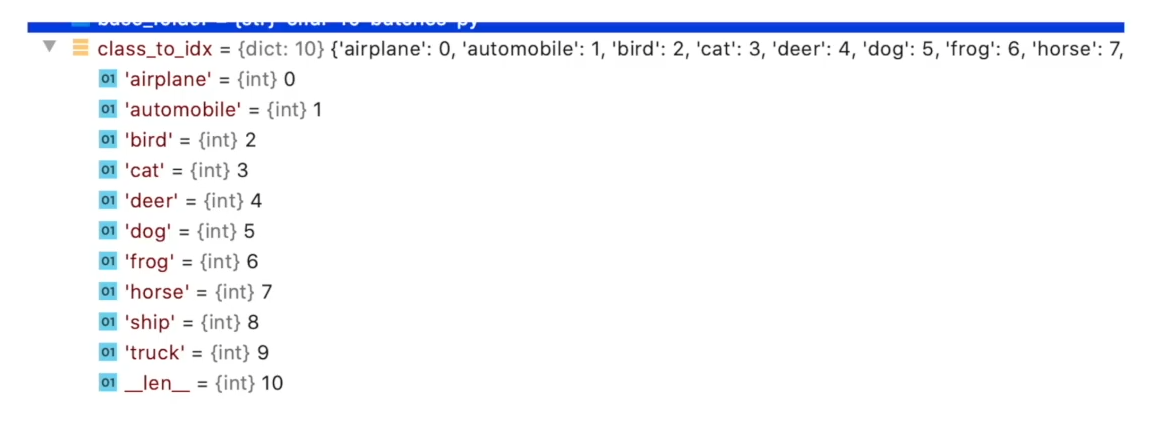